In [1]:
import torch
import os
import json
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def load_dataset(csv_dir, json_path):
    # 1. JSON読み込みと辞書化
    with open(json_path, 'r') as f:
        json_data = json.load(f)
    
    rgb_dict = {item["filename"]: item["real_rgb"] for item in json_data}

    # 2. 特徴量とラベルの蓄積
    X_list = []
    y_list = []

    for filename in os.listdir(csv_dir):
        if not filename.endswith("_masked.csv"):
            continue

        base_id = filename.replace("_masked.csv", "")  # 例: 8D5U5524

        if base_id not in rgb_dict:
            print(f"Warning: {base_id} not in JSON, skipping")
            continue

        csv_path = os.path.join(csv_dir, filename)
        df = pd.read_csv(csv_path, header=None)

        # 特徴量は1行と仮定してflatten
        features = df.values.flatten()

        X_list.append(features)

        # real_rgbからr, gの比率を計算
        R, G, B = rgb_dict[base_id]
        total = R + G + B if R + G + B != 0 else 1e-6  # 0割防止

        r_ratio = R / total
        g_ratio = G / total

        y_list.append([r_ratio, g_ratio])

    # DataFrameに変換
    X = pd.DataFrame(X_list)
    y = pd.DataFrame(y_list, columns=["r_ratio", "g_ratio"])


    return X, y

In [3]:
#load_datasetのテスト
X, y = load_dataset(csv_dir="../histpre/", json_path="../real_rgb.json")

print(X.shape)  # 特徴量の数 x サンプル数
print(y.head()) # RGBのターゲット値

print(X.iloc[0])  # 1番目のサンプルの特徴量


(5, 1324)
    r_ratio   g_ratio
0  0.311968  0.423124
1  0.305714  0.425317
2  0.366901  0.446526
3  0.354669  0.435492
4  0.358548  0.439233
0       0
1       0
2       0
3       0
4       0
       ..
1319    0
1320    0
1321    0
1322    0
1323    0
Name: 0, Length: 1324, dtype: int64


In [4]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()  # 出力を0〜1に制限

    def forward(self, x):
        # 活性化関数は使用せず、線形変換のみ
        h = self.hidden(x)  # 隠れ層（線形のみ）
        out = self.output(h)  # 出力層（線形）
        out = self.sigmoid(out)  # 0〜1に制限
        return out


In [5]:

def euclidean_loss(pred, target):
    return torch.sqrt(((pred - target) ** 2).sum(dim=1)).mean()

In [6]:
def mse_chromaticity_loss(pred, target, eps=1e-8):
    # クロマティシティ座標に変換：r = R/(R+G+B), g = G/(R+G+B)
    pred_sum = pred.sum(dim=1, keepdim=True) + eps
    target_sum = target.sum(dim=1, keepdim=True) + eps

    pred_chroma = pred[:, :2] / pred_sum  # (r, g)
    target_chroma = target[:, :2] / target_sum

    loss = ((pred_chroma - target_chroma) ** 2).mean()
    return loss


In [7]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()  # モデルを訓練モードに設定
    total_loss = 0.0

    for X_batch, y_batch in loader:
        optimizer.zero_grad()               # 勾配をリセット
        pred = model(X_batch)               # 順伝播
        loss = loss_fn(pred, y_batch)       # 損失計算
        loss.backward()                     # 逆伝播
        optimizer.step()                    # パラメータ更新

        total_loss += loss.item()           # 損失を蓄積

    average_loss = total_loss / len(loader)  # バッチ数で割る
    return average_loss

In [8]:
def evaluate(model, loader, loss_fn):
    model.eval()  # 評価モードに切り替え
    total_loss = 0.0

    with torch.no_grad():  # 勾配を計算しない（メモリ節約＆高速化）
        for X_batch, y_batch in loader:
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            total_loss += loss.item()

    average_loss = total_loss / len(loader)
    return average_loss

In [9]:
def main():
    # 1. モデル構造の再定義（構造は学習と同じに！）
    model = MLPModel(input_dim=1324, hidden_dim=256, output_dim=2)
    model.load_state_dict(torch.load("mlp_model.pth"))
    model.eval()

    # 2. テストデータの読み込み
    X_test_df, y_test_df = load_dataset("../src", "../real_rgb.json")
    X_test = torch.tensor(X_test_df.values, dtype=torch.float32)
    y_test = torch.tensor(y_test_df[["r_ratio", "g_ratio"]].values, dtype=torch.float32)

    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 3. 評価実行（クロマティシティMSE）
    test_loss = evaluate(model, test_loader, mse_chromaticity_loss)
    print(f"📊 Test Loss = {test_loss:.4f}")

    # 4. 予測と実際のRGB値の表示（5件だけ例として）
    print("\n🎨 Prediction vs Actual (first 5 samples):")
    
    num_samples = min(5, len(X_test))  # データ数に合わせる
    with torch.no_grad():
        for i in range(num_samples):
            x = X_test[i].unsqueeze(0)  # shape: (1, input_dim)
            pred = model(x)[0]          # クロマティシティ座標 (r, g)

            # モデル出力（r_pred, g_pred）
            r_pred, g_pred = pred[0].item(), pred[1].item()

            # 正解ラベル（r_true, g_true）はすでに比率
            r_true, g_true = y_test[i].numpy()

            print(f"{i+1}: Pred (r, g): ({r_pred:.4f}, {g_pred:.4f}) | True (r, g): ({r_true:.4f}, {g_true:.4f})")


In [10]:
if __name__ == "__main__":
    main()

📊 Test Loss = 0.0042

🎨 Prediction vs Actual (first 5 samples):
1: Pred (r, g): (0.4725, 0.5531) | True (r, g): (0.2777, 0.4242)


<>:21: SyntaxWarning: invalid escape sequence '\C'
<>:21: SyntaxWarning: invalid escape sequence '\C'
C:\Users\T122115\AppData\Local\Temp\ipykernel_23284\3949673728.py:21: SyntaxWarning: invalid escape sequence '\C'
  mask = load_flat_mask("D:\ColorConstancy\histogram/IMG_0316_masked.csv")


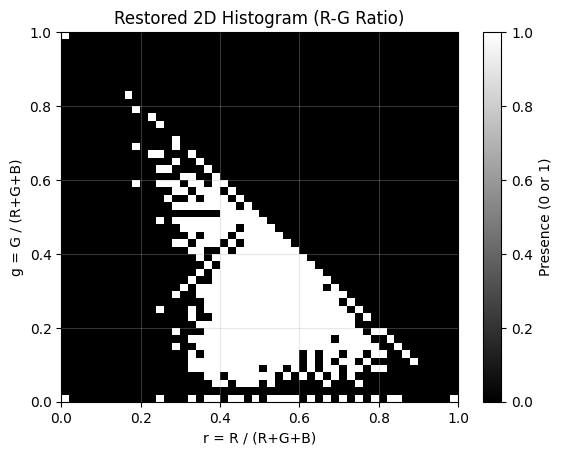

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_flat_mask(csv_path, bin_width=0.02, num_bins=50):
    # CSVから1250次元のベクトルを読み込み
    flat_mask = pd.read_csv(csv_path, header=None).values[0]

    # 50×50のマスクに復元（初期化）
    restored_mask = np.zeros((num_bins, num_bins), dtype=np.uint8)

    idx = 0
    for g in range(num_bins):  # y軸（行）
        for r in range(num_bins):  # x軸（列）
            if (r * bin_width + g * bin_width) <= 1.0:
                restored_mask[g, r] = flat_mask[idx]
                idx += 1

    return restored_mask

mask = load_flat_mask("D:\ColorConstancy\histogram/IMG_0316_masked.csv")

plt.imshow(mask.T, origin='lower', cmap='gray', extent=[0, 1, 0, 1], aspect='auto')
plt.xlabel('r = R / (R+G+B)')
plt.ylabel('g = G / (R+G+B)')
plt.title("Restored 2D Histogram (R-G Ratio)")
plt.grid(True, alpha=0.3)
plt.colorbar(label='Presence (0 or 1)')
plt.show()
